In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [5]:
# Read data from xlsx file

games = pd.read_excel('../Results.xlsx', sheet_name='Games')
turns = pd.read_excel('../Results.xlsx', sheet_name='Turns')
pve_games = games.query('GameState == "END" and (idPerson1 == 10 or idPerson2 == 10)'
                        ' and (idPerson1 not in [30, 203, 217]'
                        ' and idPerson2 not in [30, 203, 217])')
player_border_games = pve_games.query('idPerson1 == 10')
player_center_games = pve_games.query('idPerson2 == 10')
player_border_games_ids = player_border_games['idGame']
player_center_games_ids = player_center_games['idGame']

In [6]:
# Put data into arrays

player_border_turns = []
player_border_states = []
player_center_turns = []
player_center_states = []

player_center_choices = []
player_border_games_turns_timestamps = []
player_center_games_turns_timestamps = []

for i in player_border_games_ids:
    player_border_game_i_turns = turns.query('Games_idGame == ' + str(i))
    player_border_games_turns_timestamps.append(player_border_game_i_turns.sort_values(by='idTurn')['AddedTime'])
    for state in player_border_game_i_turns.sort_values(by='idTurn')['State']:
        player_border_states.append(state)
    player_border_turns.append(max(player_border_game_i_turns['idTurn']))

for i in player_center_games_ids:
    player_center_game_i_turns = turns.query('Games_idGame == ' + str(i))
    player_center_choices.append(player_center_game_i_turns.sort_values(by='idTurn')['Turn'])
    player_center_games_turns_timestamps.append(player_center_game_i_turns.sort_values(by='idTurn')['AddedTime'])
    for state in player_center_game_i_turns.sort_values(by='idTurn')['State']:
        player_center_states.append(state)
    player_center_turns.append(max(player_center_game_i_turns['idTurn']))

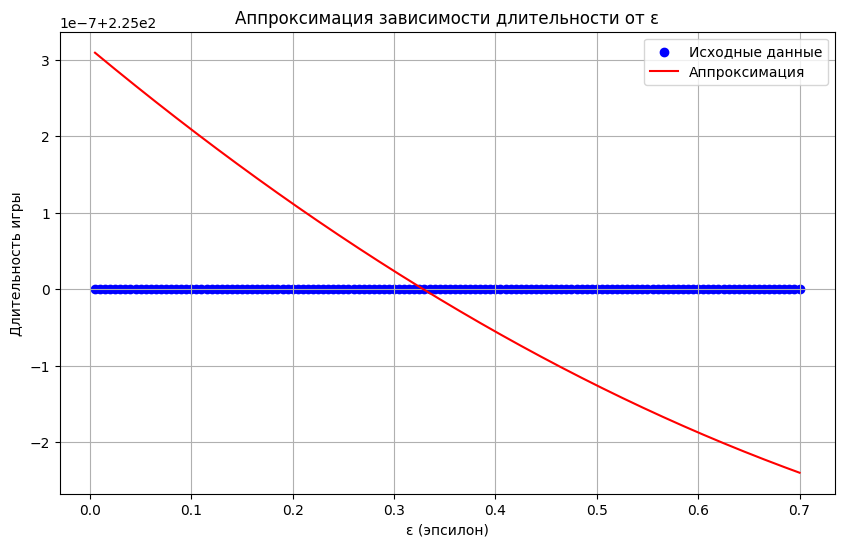

Оптимальное ε: 0.100


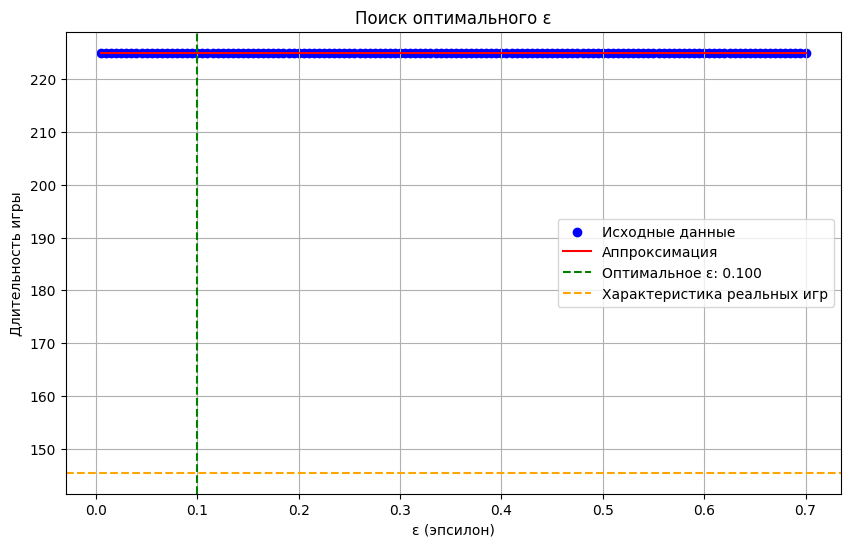

In [24]:
#Центр

import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

with open('..\\output\\eps_quarter\\pvb\\try_7\\duration.txt', 'r') as file:
    line = file.readline()

pvb_durations = list(map(float, line.split()))
epsilon_vals = np.arange(0.005, 0.705, 0.005)

epsilon_pvb_durations = list(zip(epsilon_vals, pvb_durations))

# Функция аппроксимации
def duration_model(epsilon, a, b, c):
    return a * epsilon**2 + b * epsilon + c  # Полиномиальная регрессия 2-го порядка

# Аппроксимация
params, _ = curve_fit(duration_model, epsilon_vals, pvb_durations)

# График аппроксимации
plt.figure(figsize=(10, 6))
plt.scatter(epsilon_vals, pvb_durations, label='Исходные данные', color='blue')
plt.plot(epsilon_vals, duration_model(epsilon_vals, *params), label='Аппроксимация', color='red')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Длительность игры')
plt.title('Аппроксимация зависимости длительности от ε')
plt.legend()
plt.grid()
plt.show()

# Рассчитываем ключевую характеристику: среднее, медиана или процентиль
real_duration_characteristic = np.mean(player_center_turns)


# Целевая функция: минимизировать разницу между аппроксимацией и характеристикой реальных данных
def objective_function(epsilon, *params):
    predicted_duration = duration_model(epsilon, *params)
    return abs(predicted_duration - real_duration_characteristic)

# Поиск оптимального ε
result = minimize(objective_function, x0=0.1, args=tuple(params), bounds=[(0.005, 0.705)])
optimal_epsilon = result.x[0]

print(f"Оптимальное ε: {optimal_epsilon:.3f}")


# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(epsilon_vals, pvb_durations, label='Исходные данные', color='blue')
plt.plot(epsilon_vals, duration_model(epsilon_vals, *params), label='Аппроксимация', color='red')
plt.axvline(optimal_epsilon, color='green', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.axhline(real_duration_characteristic, color='orange', linestyle='--', label='Характеристика реальных игр')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Длительность игры')
plt.title('Поиск оптимального ε')
plt.legend()
plt.grid()
plt.show()

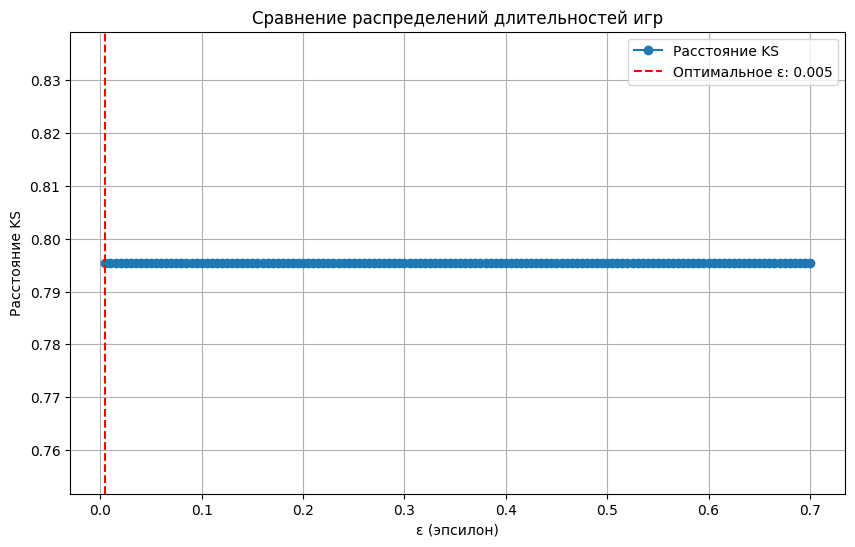

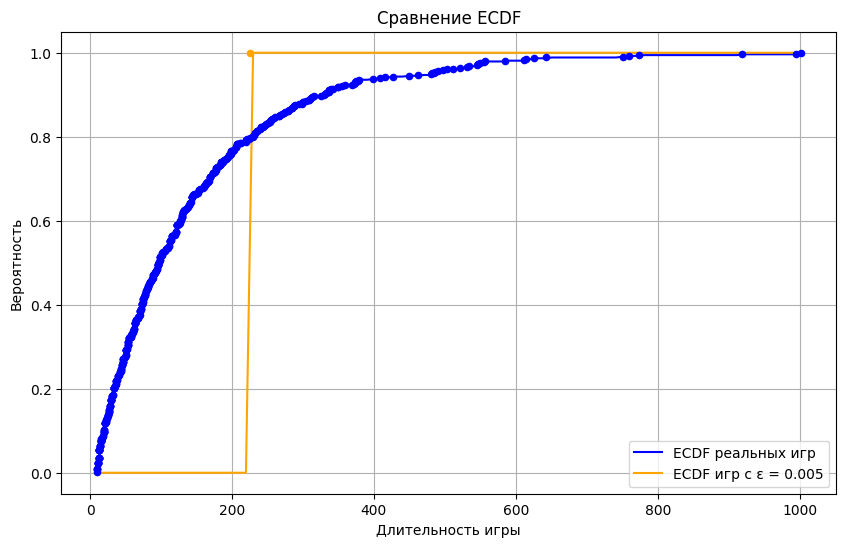

In [17]:
#Центр

with open('..\\output\\eps_quarter\\pvb\\try_7\\duration.txt', 'r') as file:
    line = file.readline()

pvb_durations = list(map(float, line.split()))
epsilon_vals = np.arange(0.005, 0.705, 0.005)

epsilon_pvb_durations = list(zip(epsilon_vals, pvb_durations))

# Хранение результатов теста KS
ks_distances = []
epsilon_values = []

# Вычисление расстояний KS
for epsilon, durations in epsilon_pvb_durations:
    ks_stat, _ = ks_2samp(player_center_turns, durations)
    ks_distances.append(ks_stat)
    epsilon_values.append(epsilon)

# Нахождение оптимального epsilon
optimal_epsilon = epsilon_values[np.argmin(ks_distances)]

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon, color='r', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений длительностей игр')
plt.legend()
plt.grid()
plt.show()

# Визуализация ECDF для оптимального ε
from statsmodels.distributions.empirical_distribution import ECDF

real_ecdf = ECDF(player_center_turns)
optimal_ecdf = ECDF([dur for eps, dur in epsilon_pvb_durations if eps == optimal_epsilon])

x = np.linspace(min(player_center_turns), max(player_center_turns), 100)

plt.figure(figsize=(10, 6))
plt.plot(x, real_ecdf(x), label='ECDF реальных игр', color='blue')
plt.plot(x, optimal_ecdf(x), label=f'ECDF игр с ε = {optimal_epsilon:.3f}', color='orange')

plt.scatter(player_center_turns, real_ecdf(player_center_turns), color='blue', s=20, zorder=5)
plt.scatter([dur for eps, dur in epsilon_pvb_durations if eps == optimal_epsilon], 
            optimal_ecdf([dur for eps, dur in epsilon_pvb_durations if eps == optimal_epsilon]), 
            color='orange', s=20, zorder=5)

plt.xlabel('Длительность игры')
plt.ylabel('Вероятность')
plt.title('Сравнение ECDF')
plt.legend()
plt.grid()
plt.show()

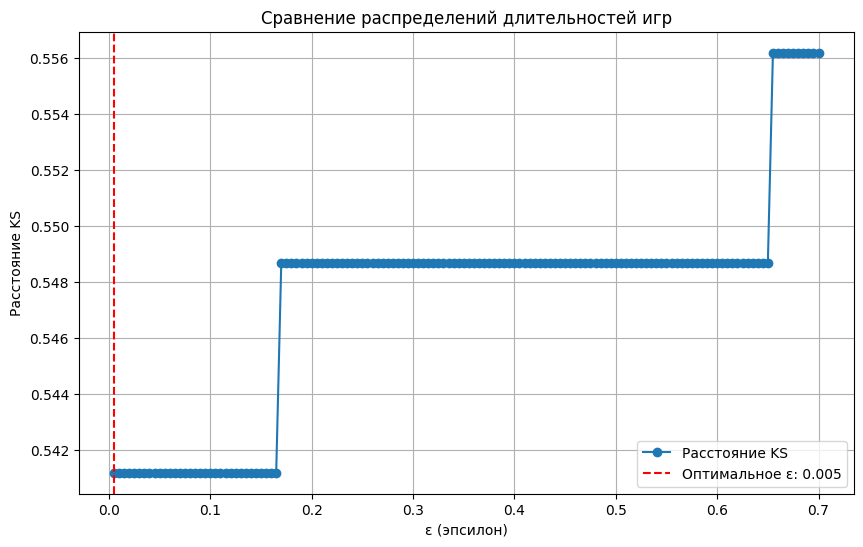

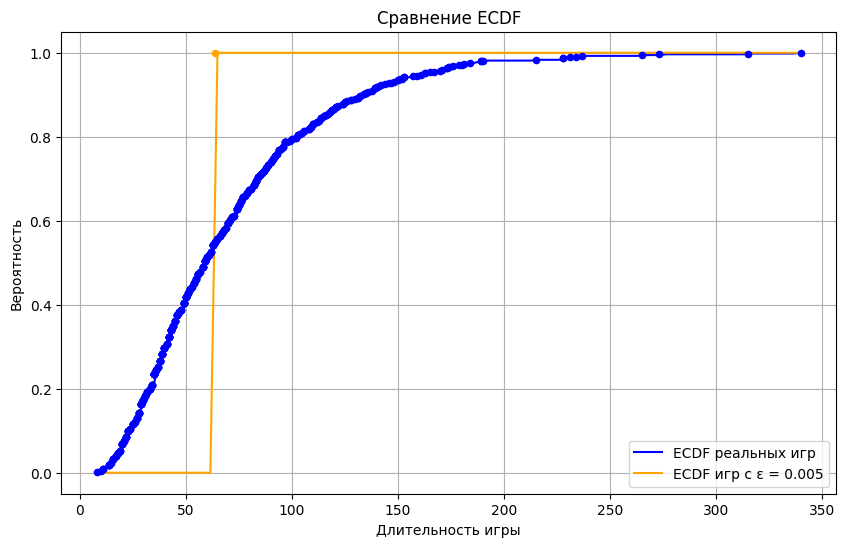

In [16]:
#Граница

with open('..\\output\\eps_quarter\\bvp\\try_6\\duration.txt', 'r') as file:
    line = file.readline()

bvp_durations = list(map(float, line.split()))
epsilon_vals = np.arange(0.005, 0.705, 0.005)

epsilon_bvp_durations = list(zip(epsilon_vals, bvp_durations))

# Хранение результатов теста KS
ks_distances = []
epsilon_values = []

# Вычисление расстояний KS
for epsilon, durations in epsilon_bvp_durations:
    ks_stat, _ = ks_2samp(player_border_turns, durations)
    ks_distances.append(ks_stat)
    epsilon_values.append(epsilon)

# Нахождение оптимального epsilon
optimal_epsilon = epsilon_values[np.argmin(ks_distances)]

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, ks_distances, marker='o', label='Расстояние KS')
plt.axvline(optimal_epsilon, color='r', linestyle='--', label=f'Оптимальное ε: {optimal_epsilon:.3f}')
plt.xlabel('ε (эпсилон)')
plt.ylabel('Расстояние KS')
plt.title('Сравнение распределений длительностей игр')
plt.legend()
plt.grid()
plt.show()

# Визуализация ECDF для оптимального ε
from statsmodels.distributions.empirical_distribution import ECDF

real_ecdf = ECDF(player_border_turns)
optimal_ecdf = ECDF([dur for eps, dur in epsilon_bvp_durations if eps == optimal_epsilon])

x = np.linspace(min(player_border_turns), max(player_border_turns), 100)

plt.figure(figsize=(10, 6))
plt.plot(x, real_ecdf(x), label='ECDF реальных игр', color='blue')
plt.plot(x, optimal_ecdf(x), label=f'ECDF игр с ε = {optimal_epsilon:.3f}', color='orange')

plt.scatter(player_border_turns, real_ecdf(player_border_turns), color='blue', s=20, zorder=5)
plt.scatter([dur for eps, dur in epsilon_bvp_durations if eps == optimal_epsilon], 
            optimal_ecdf([dur for eps, dur in epsilon_bvp_durations if eps == optimal_epsilon]), 
            color='orange', s=20, zorder=5)

plt.xlabel('Длительность игры')
plt.ylabel('Вероятность')
plt.title('Сравнение ECDF')
plt.legend()
plt.grid()
plt.show()